In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,43423,None,None,85797.408172
2020-06-13,43424,None,None,79701.721473
2020-06-14,43425,None,None,74048.003951
2020-06-15,43426,None,None,68722.383847
2020-06-16,43427,None,None,63978.143258
...,...,...,...,...
2021-03-28,43712,None,None,69348.642027
2021-03-29,43713,None,None,68307.799746
2021-03-30,43714,None,None,67000.252672


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-01_2021-04-01-15-15.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-31_2021-03-31-16-26.pickle


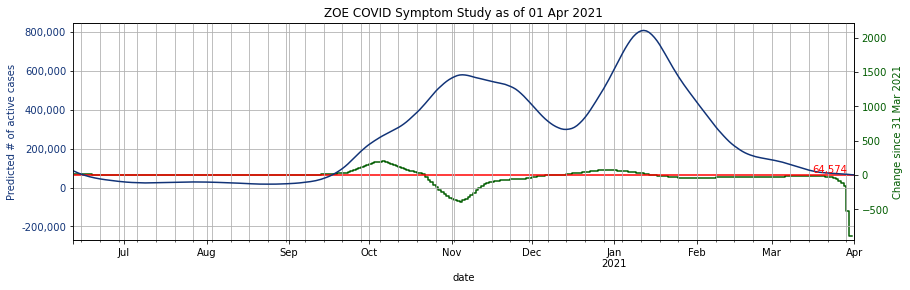

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

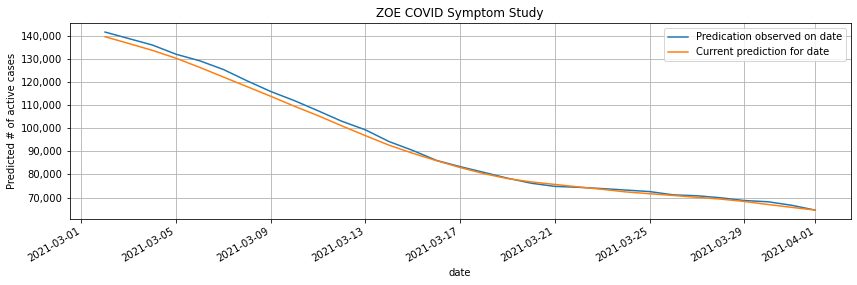

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-01_2021-04-01-15-15.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
323,North Lanarkshire,S12000044,1.479942
358,Belfast,N09000003,0.848343
328,Conwy,W06000003,0.561147
153,North West Leicestershire,E07000134,0.512365
25,Leicester,E06000016,0.509371
150,Dover,E07000108,0.442662
17,North East Lincolnshire,E06000012,0.416384
317,Renfrewshire,S12000038,0.407014
256,Bromsgrove,E07000234,0.372113
387,Powys,W06000023,0.302599
